# SETUP

### Import all dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.model_selection import train_test_split

### import CIFAR-10

In [5]:
# 1. Download CIFAR-10
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# 2. Access data and targets
X_train = np.array([np.array(x) for x, y in cifar10_train])
y_train = np.array([y for x, y in cifar10_train])

X_test = np.array([np.array(x) for x, y in cifar10_test])
y_test = np.array([y for x, y in cifar10_test])

# Map from class index to class name.
classes = {index: name for name, index in cifar10_train.class_to_idx.items()}

100%|██████████| 170498071/170498071 [01:29<00:00, 1914799.95it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# 3. Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

### Normalize X

In [7]:
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

In [8]:
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print("X_train min/max:", X_train.min(), X_train.max())
print("X_val min/max:", X_val.min(), X_val.max())
print("X_test min/max:", X_test.min(), X_test.max())

X_train min/max: -1.9909929603437044 2.1295387686331444
X_val min/max: -1.9909929603437044 2.1295387686331444
X_test min/max: -1.9909929603437044 2.1295387686331444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998663434504684..2.060509188754882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6451045108903888..2.1295387686331444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7740329848464964..2.0811459060751503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6414515984606892..1.0436615905497466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9115517417339283..1.5810863263092125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9193307320523547..2.0811459060751503].


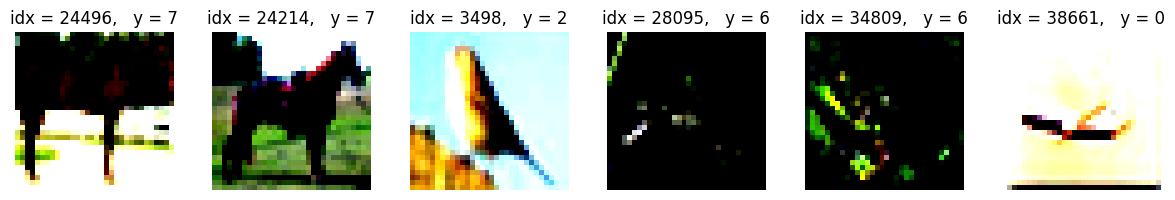

In [9]:
def plot_random_examples(X, y, num_examples=5):
    """
    Plots a given number of random examples from the dataset.
    """
    num_images = X.shape[0]

    plt.figure(figsize=(num_examples * 2, 2))
    random_indices = np.random.choice(num_images, num_examples, replace=False)

    for i, idx in enumerate(random_indices):
        image = X[idx].reshape(32, 32, 3)  # Reshape for CIFAR-10
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"idx = {idx},   y = {y[idx]}")

    plt.tight_layout()
    plt.show()

plot_random_examples(X_train, y_train, 6)

### Define Classification Class

In [10]:
import torch.nn.init as init

In [11]:
class CIFAR10ClassifierModule(nn.Module):
    def __init__(self, num_classes=10):  # Keep num_classes for CIFAR-10
        super(CIFAR10ClassifierModule, self).__init__()

        # Use the same dimensions as CIFAR-10 model
        self.dim1 = 24
        self.dim2 = 32
        self.dim3 = 64

        # Input channels changed to 3 for CIFAR-10 (RGB images)
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=self.dim1, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(self.dim1)
        self.relu1 = nn.ReLU()

        self.conv_layer2 = nn.Conv2d(in_channels=self.dim1, out_channels=self.dim2, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(self.dim2)
        self.relu2 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=self.dim2, out_channels=self.dim3, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(self.dim3)
        self.relu3 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate conv_dim based on CIFAR-10 image size (32x32)
        self.conv_dim = self.dim3 * (32 // 4) ** 2

        self.fc_layer1 = nn.Linear(self.conv_dim, self.conv_dim // 4)
        self.relu4 = nn.ReLU()

        # Use the same dropout as CIFAR-10 model (p=0.3)
        self.dropout = nn.Dropout(p=0.3)

        self.fc_layer2 = nn.Linear(self.conv_dim // 4, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                init.constant_(module.bias, 0)

    def forward(self, X, **kwargs):
        feature_maps = {}

        X = self.conv_layer1(X)
        X = self.batchnorm1(X)
        X = self.relu1(X)
        feature_maps['conv1'] = X

        X = self.conv_layer2(X)
        X = self.batchnorm2(X)
        X = self.relu2(X)
        feature_maps['conv2'] = X

        X = self.pool1(X)
        #feature_maps['pool1'] = X

        X = self.conv_layer3(X)
        X = self.batchnorm3(X)
        X = self.relu3(X)
        feature_maps['conv3'] = X

        X = self.pool2(X)
        feature_maps['pool2'] = X

        X = X.reshape(X.size(0), -1)
        X = self.fc_layer1(X)
        X = self.relu4(X)
        X = self.dropout(X)
        X = self.fc_layer2(X)

        return X, feature_maps


model = CIFAR10ClassifierModule()
print(model)

CIFAR10ClassifierModule(
  (conv_layer1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv_layer2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layer1): Linear(in_features=4096, out_features=1024, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_layer2): Linear(in_features=1024, out_features=10, bias=True)
)


In [12]:
def print_weights(model):
      for name, module in model.named_modules():
          if hasattr(module, 'weight') and module.weight is not None:
              print(f"Module: {name}")
              print("Weights:")
              print(module.weight)
              print()
          if hasattr(module, 'bias') and module.bias is not None:
              print(f"Module: {name}")
              print("Biases:")
              print(module.bias)
              print()

print_weights(model)

Module: conv_layer1
Weights:
Parameter containing:
tensor([[[[ 3.7384e-01, -2.3694e-01, -3.6019e-01],
          [-4.4579e-01, -6.8524e-02,  3.6948e-01],
          [ 1.8530e-01, -3.0656e-01,  2.0871e-01]],

         [[ 2.7247e-01,  2.1116e-01, -8.7267e-02],
          [ 4.4889e-01, -9.9501e-04, -6.9257e-02],
          [-3.4185e-01, -4.8345e-01,  3.8348e-01]],

         [[ 8.8548e-02,  2.3960e-01, -1.3761e-01],
          [ 3.5715e-01, -7.7526e-02, -9.4858e-02],
          [-3.9228e-01, -2.5389e-01, -2.4775e-02]]],


        [[[ 1.4277e-01,  1.2901e-01, -2.7737e-01],
          [ 8.3573e-02, -1.1497e-01,  8.9862e-02],
          [-2.4897e-01, -3.9257e-01,  2.5793e-01]],

         [[-2.1541e-02,  2.6004e-01,  1.0934e-01],
          [-8.3600e-02,  2.0676e-02, -3.4466e-01],
          [ 1.0812e-01,  1.3451e-01,  1.7147e-02]],

         [[-8.6301e-02,  2.5478e-01,  1.4496e-01],
          [-2.9048e-01,  2.4556e-01,  6.2481e-01],
          [ 9.2257e-01,  5.8468e-02,  4.0452e-01]]],


        [[[ 6.6

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay=1e-4)

### Feature Map Plots

Layer conv1: 24 feature maps


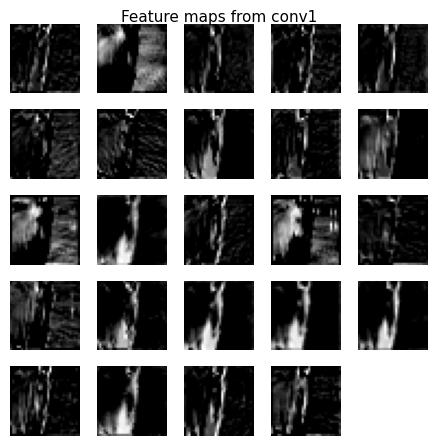

Layer conv2: 32 feature maps


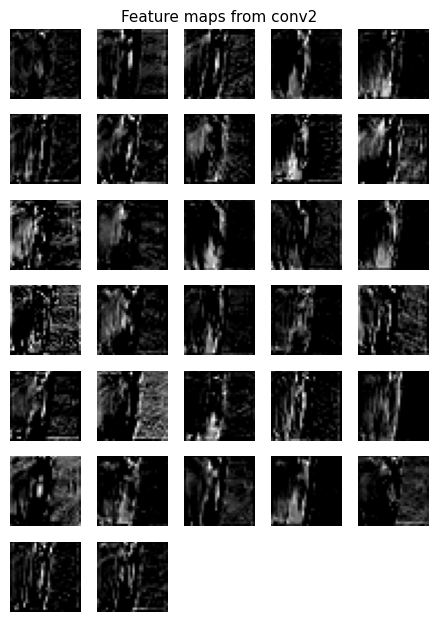

Layer conv3: 64 feature maps


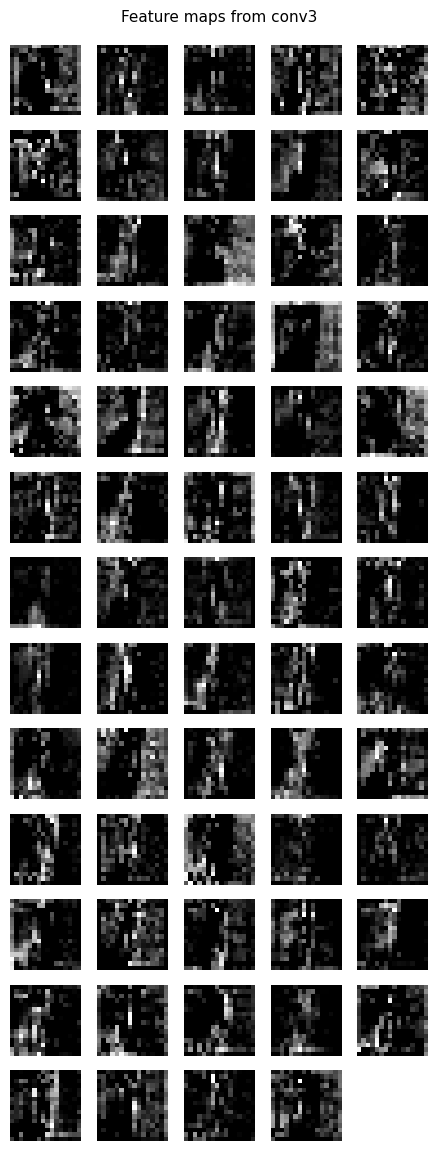

Layer pool2: 64 feature maps


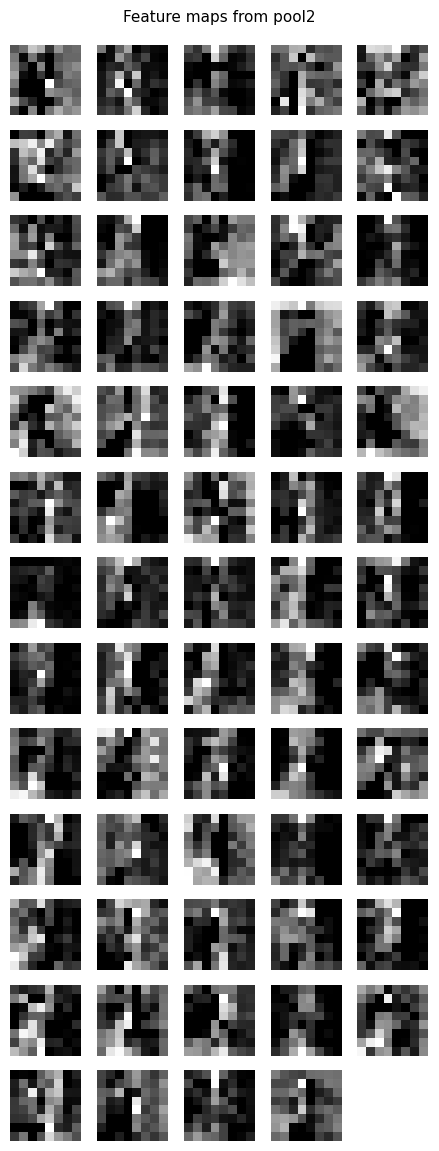

In [15]:
def plot_feature_maps(feature_maps):
    for layer_name, fmap in feature_maps.items():
        num_feature_maps = fmap.shape[1]  # Number of channels (feature maps)
        num_cols = min(5, num_feature_maps)  # Up to 5 columns
        num_rows = int(np.ceil(num_feature_maps / num_cols))  # Calculate rows based on columns

        print(f"Layer {layer_name}: {num_feature_maps} feature maps")

        size_param = 0.3

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15 * size_param, 3 * num_rows * size_param))
        fig.suptitle(f"Feature maps from {layer_name}", fontsize=11)

        # Flatten axes for easier iteration and handle cases with fewer subplots
        if num_feature_maps > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for i in range(num_feature_maps):
            fmap_to_plot = fmap[0, i].detach().cpu().numpy()
            # Normalize the feature map to the range [0, 1] for display purposes
            fmap_to_plot = (fmap_to_plot - np.min(fmap_to_plot)) / (np.max(fmap_to_plot) - np.min(fmap_to_plot))

            if fmap_to_plot.ndim == 2:
                axes[i].imshow(fmap_to_plot, cmap='gray')
            else:
                fmap_to_plot = np.transpose(fmap_to_plot, (1, 2, 0))
                axes[i].imshow(fmap_to_plot)

            axes[i].axis('off')

        for i in range(num_feature_maps, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

sample_image = X_train[np.random.randint(low=0, high=X_train.shape[0]), :]
sample_image = torch.tensor(sample_image, dtype=torch.float32).unsqueeze(0)
sample_image = sample_image.permute(0, 3, 1, 2)  # Permute to (batch_size, channels, height, width)
sample_image = sample_image.to(next(model.parameters()).device)
output, feature_maps = model(sample_image)

plot_feature_maps(feature_maps)

The above are plots for the initialized weights.

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and create data loaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Permute to (batch_size, channels, height, width)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 8
validation_every_steps = 100

step = 0
model.train()

train_losses = []
val_losses = []
train_accuracies = []
valid_accuracies = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define accuracy calculation
def accuracy(targets, predictions):
    return (targets == predictions).sum().item() / targets.size(0)

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        output, _ = model(inputs)

        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        train_losses.append(loss.item())

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            val_loss_total = 0.0
            with torch.no_grad():
                model.eval()
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output, _ = model(inputs)
                    val_loss = criterion(output, targets)
                    val_loss_total += val_loss.item()

                    predictions = output.max(1)[1]

                    # Multiply by len(inputs) because the final batch of DataLoader may be smaller.
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy and loss to lists.
            val_losses.append(val_loss_total / len(val_loader))
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_dataset))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")

print("Finished training.")

Step 100     training accuracy: 0.2952
             test accuracy: 0.3999
Step 200     training accuracy: 0.3962
             test accuracy: 0.4693
Step 300     training accuracy: 0.4423
             test accuracy: 0.4957
Step 400     training accuracy: 0.4823
             test accuracy: 0.5385
Step 500     training accuracy: 0.5120
             test accuracy: 0.5554
Step 600     training accuracy: 0.5219
             test accuracy: 0.5516
Step 700     training accuracy: 0.5706
             test accuracy: 0.6059
Step 800     training accuracy: 0.5866
             test accuracy: 0.6112
Step 900     training accuracy: 0.6012
             test accuracy: 0.6375
Step 1000    training accuracy: 0.5961
             test accuracy: 0.6246
Step 1100    training accuracy: 0.6064
             test accuracy: 0.6380
Step 1200    training accuracy: 0.6158
             test accuracy: 0.6439
Step 1300    training accuracy: 0.6550
             test accuracy: 0.6503
Step 1400    training accuracy: 0.6548

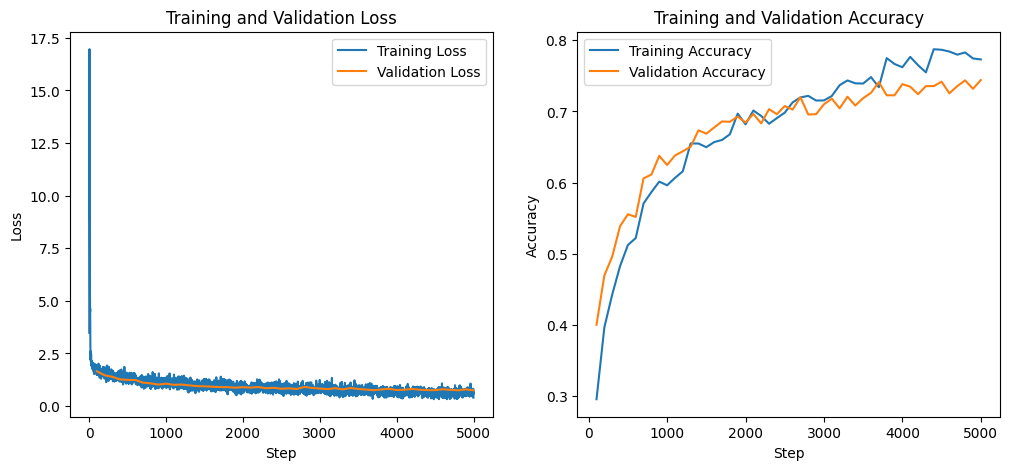

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot([i * validation_every_steps for i in range(1, len(val_losses) + 1)], val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i * validation_every_steps for i in range(1, len(train_accuracies) + 1)], train_accuracies, label='Training Accuracy')
plt.plot([i * validation_every_steps for i in range(1, len(valid_accuracies) + 1)], valid_accuracies, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99549645..1.5647694].


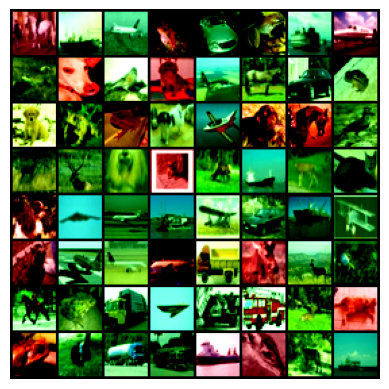

    Incorrect  Predictions    
    TRUE        PREDICTED
-----------------------------
    horse          dog     
    frog          deer     
  airplane        ship     
     dog           cat     
     dog           cat     
    frog          bird     
     dog          bird     
    horse          dog     
     dog           cat     
     dog          deer     
     cat          bird     
  airplane        ship     
    deer           dog     
     cat           dog     
    frog           dog     
    ship        airplane   
    deer           cat     


In [18]:
from torchvision.utils import make_grid

def apply_color_filter(image, is_correct):
    """Apply a green or red filter to the image based on correctness."""
    color_filter = torch.tensor([0.0, 1.0, 0.0]) if is_correct else torch.tensor([1.0, 0.0, 0.0])
    return image * 0.5 + color_filter.view(3, 1, 1) * 0.5

def show_image(img, labels, predictions):
    """Display images with color filters for correct/incorrect predictions."""
    images_with_filters = [apply_color_filter(img[i], labels[i] == predictions[i]) for i in range(labels.size(0))]
    plt.imshow(np.transpose(make_grid(torch.stack(images_with_filters)).numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_model(model, test_loader, device, classes):
    """Test the model and display incorrectly predicted images with labels."""
    model.eval()
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs, 1)

    show_image(inputs.cpu(), targets, predicted)

    # Print only incorrect predictions
    print("    Incorrect  Predictions    ")
    print("    TRUE        PREDICTED")
    print("-----------------------------")
    for target, pred in zip(targets, predicted):
        if target != pred:
            print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

test_model(model, val_loader, device, classes)

### Plot a feature map for the same sample image, now with the trained network

Layer conv1: 24 feature maps


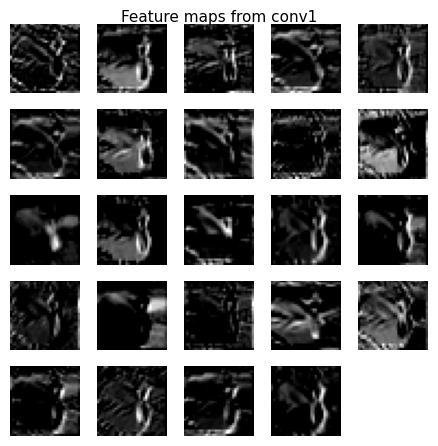

Layer conv2: 32 feature maps


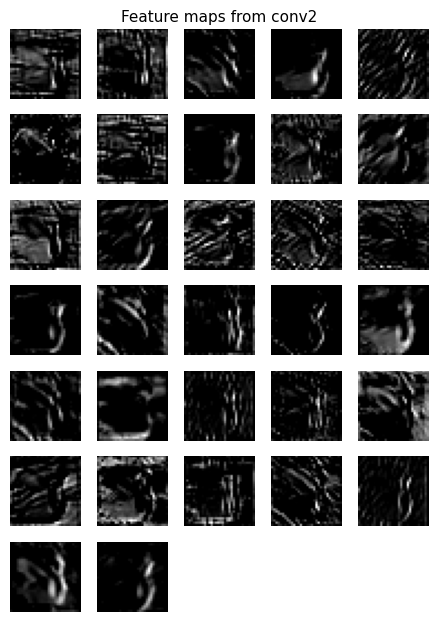

Layer conv3: 64 feature maps


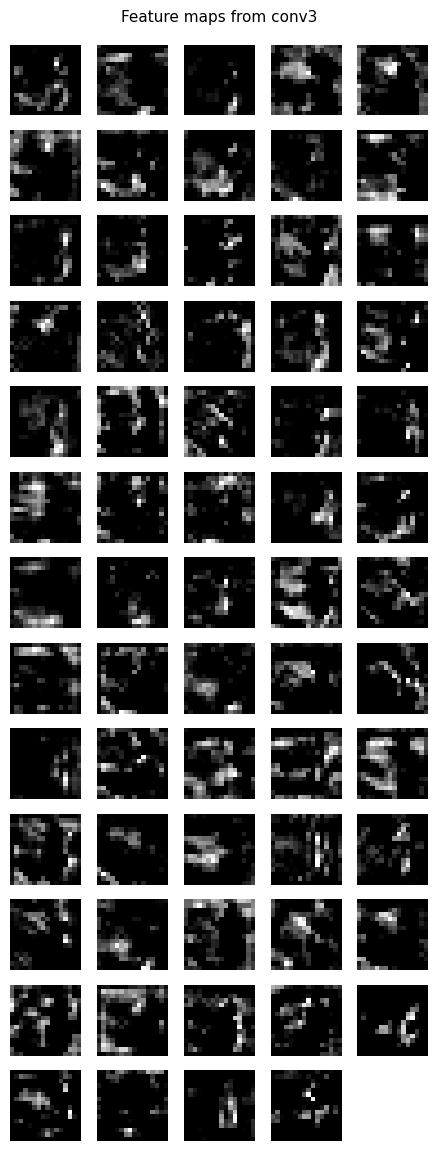

Layer pool2: 64 feature maps


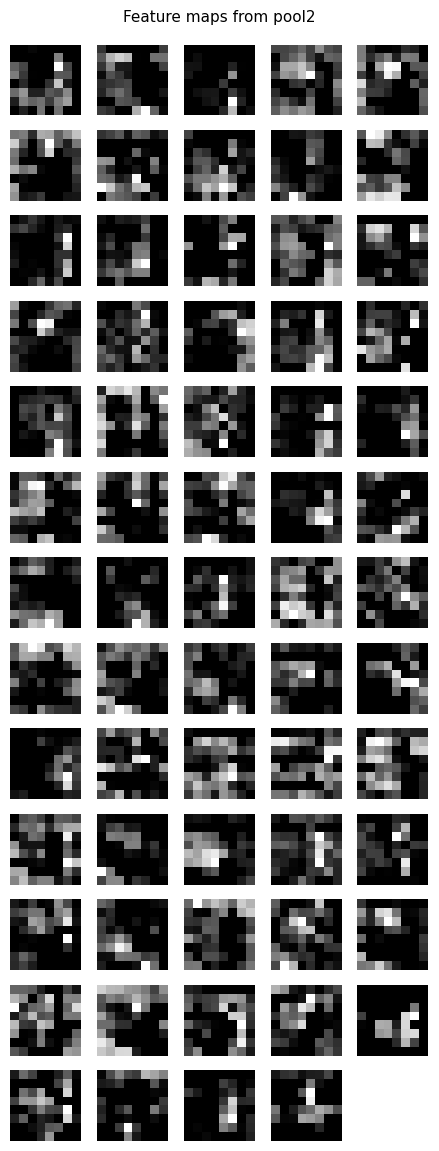

In [ ]:
#sample_image = X_train[np.random.randint(low=0, high=X_train.shape[0]), :].reshape(1, 28, 28)
#sample_image = torch.tensor(sample_image, dtype=torch.float32).unsqueeze(0)
#sample_image = sample_image.to(next(model.parameters()).device)
sample_image = sample_image.to(device)
output, feature_maps = model(sample_image)

plot_feature_maps(feature_maps)

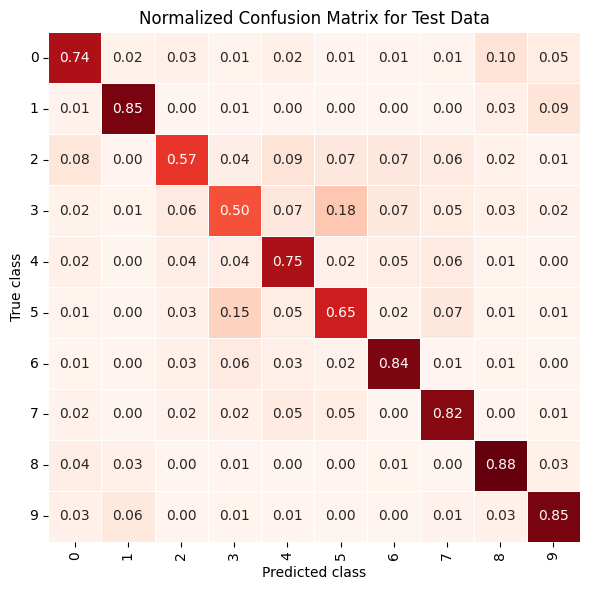

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def normalize(matrix, axis):
    """Normalize a confusion matrix along the specified axis (0 for predictions, 1 for true labels)."""
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

def plot_confusion_matrix(model, inputs, targets, device, classes, dataset_name="Test"):
    """Plot a normalized confusion matrix for the given model and the full dataset."""
    model.eval()
    all_preds = []

    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(targets.cpu().numpy(), all_preds)

    conf_matrix_normalized = normalize(conf_matrix, 'true')

    x_labels = [classes[i] for i in range(len(classes))]
    y_labels = x_labels
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        data=conf_matrix_normalized,
        annot=True,
        linewidths=0.5,
        cmap="Reds",
        cbar=False,
        fmt=".2f",
        xticklabels=x_labels,
        yticklabels=y_labels
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.title(f"Normalized Confusion Matrix for {dataset_name} Data")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, X_test_tensor, y_test_tensor, device, list(range(10)), dataset_name="Test")


### Active Learning with CIFAR-10 and Entropy-Based Uncertainty Sampling

In this section, we use the CIFAR-10 dataset in an active learning approach. We initialize a model with a small subset of labeled data, evaluate its predictions on an unlabeled dataset, and gradually add high-uncertainty samples to the training data based on entropy.


In [ ]:
import torch.nn.init as init
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Subset

class ActiveLearningTrainer:
    def __init__(self, model, criterion, optimizer, train_data, val_data, unlabeled_data, batch_size=128,device = None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_data = train_data
        self.val_data = val_data
        self.unlabeled_data = unlabeled_data
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)
        self.unlabeled_loader = DataLoader(self.unlabeled_data, batch_size=batch_size, shuffle=False)
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        
    def entropy_score(self, outputs):
        """Compute entropy of the model's outputs to measure uncertainty."""
        probabilities = F.softmax(outputs, dim=1)
        entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)
        return entropy
    
    def select_samples(self, num_samples):
        """Select samples with the highest entropy from the unlabeled data."""
        self.model.eval()
        entropies = []
        indices = []
        
        # Calculate entropy for each sample in the unlabeled set
        with torch.no_grad():
            for idx, (inputs, _) in enumerate(self.unlabeled_loader):
                inputs = inputs.to(next(self.model.parameters()).device)
                outputs, _ = self.model(inputs)
                entropy = self.entropy_score(outputs)
                entropies.extend(entropy.cpu().numpy())
                indices.extend([idx * self.unlabeled_loader.batch_size + i for i in range(len(inputs))])
        
        # Select samples with the highest entropy
        selected_indices = np.argsort(entropies)[-num_samples:]
        return [indices[i] for i in selected_indices]

    def add_to_train_set(self, selected_indices):
        """Add selected high-entropy samples to the training set."""
        new_train_indices = list(range(len(self.train_data))) + selected_indices
        self.train_data = Subset(self.train_data + self.unlabeled_data, new_train_indices)
        self.train_loader = DataLoader(self.train_data, batch_size=self.train_loader.batch_size, shuffle=True)

    def train_epoch(self):
        """Train for one epoch with the current training data."""
        self.model.train()
        running_loss = 0.0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device).long()
            
            self.optimizer.zero_grad()
            outputs, _ = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate(self):
        self.model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
    
        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device).long()
                outputs, _ = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
    
                _, preds = torch.max(outputs, 1)
                running_corrects += (preds == labels).sum().item()
                total_samples += labels.size(0)
    
        avg_loss = running_loss / total_samples
        accuracy = running_corrects / total_samples
        return avg_loss, accuracy


    def active_learning_training(self, num_epochs, num_samples_per_epoch):
        """Main training loop with active learning."""
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            
            # Train on current labeled training data
            train_loss = self.train_epoch()
            print(f"Training Loss: {train_loss:.4f}")
            
            # Validate the model
            val_loss, val_accuracy = self.validate()
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            
            # Active learning step: select and add new samples
            selected_indices = self.select_samples(num_samples=num_samples_per_epoch)
            self.add_to_train_set(selected_indices)
            print(f"Added {len(selected_indices)} new samples to the training set.\n")


In [ ]:

from torch.utils.data import random_split, TensorDataset

# Define initial labeled and unlabeled datasets
initial_train_size = 5000  # Small initial training set
val_size = 1000  # Validation set size
unlabeled_size = len(X_train) - initial_train_size - val_size

# Convert CIFAR-10 numpy arrays to TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train).permute(0, 3, 1, 2).float(), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test).permute(0, 3, 1, 2).float(), torch.tensor(y_test))

# Split CIFAR-10 into labeled training, validation, and unlabeled sets
train_data, val_data, unlabeled_data = random_split(train_dataset, [initial_train_size, val_size, unlabeled_size])


In [ ]:

# Initialize model and set up criterion, optimizer, and trainer
model = CIFAR10ClassifierModule(num_classes=10)  # Reuse model class from above
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize ActiveLearningTrainer
trainer = ActiveLearningTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_data=train_data,
    val_data=val_data,
    unlabeled_data=unlabeled_data,
    batch_size=128
)

# Start active learning training
num_epochs = 20  # Total number of training epochs
num_samples_per_epoch = 100  # Number of high-entropy samples to add each epoch
trainer.active_learning_training(num_epochs, num_samples_per_epoch)


Epoch 1/20
Training Loss: 4.1669
Validation Loss: 1.9205, Accuracy: 0.3140
Added 100 new samples to the training set.

Epoch 2/20
Training Loss: 1.8118
Validation Loss: 1.6533, Accuracy: 0.4090
Added 100 new samples to the training set.

Epoch 3/20
Training Loss: 1.6299
Validation Loss: 1.5472, Accuracy: 0.4330
Added 100 new samples to the training set.

Epoch 4/20
Training Loss: 1.5091
Validation Loss: 1.4688, Accuracy: 0.4720
Added 100 new samples to the training set.

Epoch 5/20
Training Loss: 1.3950
Validation Loss: 1.3522, Accuracy: 0.4970
Added 100 new samples to the training set.

Epoch 6/20
Training Loss: 1.2826
Validation Loss: 1.3073, Accuracy: 0.5200
Added 100 new samples to the training set.

Epoch 7/20
Training Loss: 1.1949
Validation Loss: 1.2902, Accuracy: 0.5200
Added 100 new samples to the training set.

Epoch 8/20
Training Loss: 1.1108
Validation Loss: 1.2421, Accuracy: 0.5490
Added 100 new samples to the training set.

Epoch 9/20
Training Loss: 1.0134
Validation Loss